# ΟΣ2 ΙΙ (2023-24): Αποτελέσματα SAP2000 - Περιβάλλουσες

In [44]:
#!pip install streng

In [45]:
from streng.codes.eurocodes.ec8.cls.seismic_action.spectra import SpectraEc8
from streng.codes.eurocodes.ec2.raw.ch5.geometric_data import effective_width
from streng.ppp.sections.geometry.tee import TeeSectionGeometry
from streng.ppp.sections.geometry.rectangular import RectangularSectionGeometry
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import openseespy.opensees as ops
import opsvis as opsv
import pandas as pd

## Δεδομένα

### Μεταβλητές φοιτητή

κ, λ τα τελευταία δύο ψηφία του ΑΕΜ, πχ για ΑΕΜ 1234 ή CIV91234 θα είναι κ=3, λ=4

In [21]:
κ = 0
λ = 0

### Διαστάσεις φορέα

$L = 19.80 - 0.1 * κ$

$H = 6.40 - 0.1 * λ$

$α = L / 4$

$L_1 = L / 2$

In [22]:
L = 19.80 - 0.1 * κ
H = 6.40 - 0.1 * λ
α = L / 4
L1 = L / 2

print(f'L = {L:.2f}m')
print(f'H = {H:.2f}m')
print(f'α = {α:.3f}m')
print(f'L1 = {L1:.3f}m')

L = 19.80m
H = 6.40m
α = 4.950m
L1 = 9.900m


### Διαστάσεις διατομών

Σε όλα τα δομικά στοιχεία να θεωρηθεί ότι η ονομαστική τιμή της επικάλυψης των οπλισμών είναι 35mm

In [23]:
cnom = 0.035 # m

#### Δοκοί

$b_w = 0.40\text{m}$

$h_f = 0.20\text{m}$

$h = 1.20\text{m}$ για $λ\le4$

$h = 1.10\text{m}$ για $λ\ge 5$

Το συνεργαζόμενο πλάτος $b_{eff}$ να υπολογιστεί σύμφωνα με τις σχέσεις του EC2

In [24]:
# Διαστάσεις δοκών
bw = 0.40
hf = 0.20
if λ <= 4:
    h = 1.20
else:
    h = 1.10

print(f'bw = {bw:.2f}m')
print(f'h = {h:.2f}m')
print(f'hf = {hf:.2f}m')
print(f'h - hf = {h - hf:.2f}m')

bw = 0.40m
h = 1.20m
hf = 0.20m
h - hf = 1.00m


#### Υπολογισμός συνεργαζόμενου πλάτους

Η θεωρητική απόσταση ανάμεσα σε δύο σημεία μηδενισμού των ροπών είναι:
$l_0 = 0.7\cdot L_1 = 7.00\text{m}$ για μεσαίο άνοιγμα (ροπή και στις δύο στηρίξεις)

Η καθαρή απόσταση ανάμεσα σε δύο δοκούς στην εγκάρσια διεύθυνση είναι:

$L_{n,εγκ1} = L_{n,εγκ2} = α - 2 * \dfrac{b_w}{2}$

$b_1 = b_2 = \dfrac{L_{n,εγκ1}}{2}$

$b = b_w + b_1 + b_2$

$b_{eff,i}=0.2\cdot b_i +0.1\cdot l_0 \le 0.2\cdot l_0$

$b_{eff,1} = b_{eff,2} = 0.2 * 2.30 + 0.1 * 7.0  < 0.2 \cdot l_0$

In [25]:
l0 = effective_width.l0(l2 = L1, zero_moments_case=2)
ln_eg1 = ln_eg2 = α - bw
b1 = b2 = ln_eg1 / 2.0
_b = bw + b1 + b2
beff1 = beff2 = effective_width.beffi(b1, l0)
beff = beff2 = effective_width.beff(bw, beff1, beff2, _b)

print(f'l0 = {l0:.3f}m')
print(f'Ln,εγκ1 = Ln,εγκ2 = {ln_eg1:.3f}m')
print(f'b1 = b2 = {b1:.3f}m')
print(f'b = {_b:.3f}m')
print(f'beff1 = beff2 = {beff1:.3f}m')
print(f'beff = {beff:.3f}m')

l0 = 6.930m
Ln,εγκ1 = Ln,εγκ2 = 4.550m
b1 = b2 = 2.275m
b = 4.950m
beff1 = beff2 = 1.148m
beff = 2.696m


#### Στύλοι 
(χρησιμοποιώ δείκτη **c**(olumn) ώστε να μη γίνεται σύγχυση με τις διαστάσεις των δοκών)

$b_c = 0.40\text{m}$

$h_c = 1.10\text{m}$ για $λ\le4$

$h_c = 1.00\text{m}$ για $λ\ge 5$

In [26]:
# Διαστάσεις στύλων
bc = 0.40
if λ <= 4:
    hc = 1.10
else:
    hc = 1.00
print(f'bc = {bc:.2f}m')    
print(f'hc = {hc:.2f}m')

bc = 0.40m
hc = 1.10m


## Φορτία

Πάχος επιστρώσεων: $h_{επιστ} = 0.06 - 0.004 \cdot λ$ (m)

Ύψος τοιχοπληρώσεων: $h_{hτοιχ} = 2.7 + 0.05 \cdot κ$ (m)

Ειδικά βάρη:

$γ_{σκυρ} = 25.0$ (kN/m3)

$γ_{επιστ} = 21.5 - 0.3 \cdot λ$ (kN/m3)

$γ_{τοιχ} = 3.6$ (kN/m2)

In [27]:
hεπιστ = 0.06 - 0.004 * λ
hτοιχ = 2.7 + 0.05 * κ

γσκυρ = 25.0 # kN/m3
γεπιστ = 21.5 - 0.3 * λ
γτοιχ = 3.6

print(f'hεπιστ = {hεπιστ:.3f}m')
print(f'hτοιχ = {hτοιχ:.3f}m')  
print(f'γσκυρ = {γσκυρ:.2f}kN/m3')  
print(f'γεπιστ = {γεπιστ:.2f}kN/m3')  
print(f'γτοιχ = {γτοιχ:.2f}kN/m2')   

hεπιστ = 0.060m
hτοιχ = 2.700m
γσκυρ = 25.00kN/m3
γεπιστ = 21.50kN/m3
γτοιχ = 3.60kN/m2


### Φορτία πλακών

#### Μόνιμα φορτία πλακών

In [28]:
Gπλ_ιβ = γσκυρ * hf
Gπλ_επιστ = γεπιστ * hεπιστ
Gπλ_ολ = Gπλ_ιβ + Gπλ_επιστ

print(f'Gπλ_ιβ = {Gπλ_ιβ:.2f}kN/m2')
print(f'Gπλ_επιστ = {Gπλ_επιστ:.2f}kN/m2')
print(f'Gπλ_ολ = {Gπλ_ολ:.2f}kN/m2')

Gπλ_ιβ = 5.00kN/m2
Gπλ_επιστ = 1.29kN/m2
Gπλ_ολ = 6.29kN/m2


#### Ωφέλιμα φορτία πλακών

In [29]:
Qπλ = 5.0 # kN/m2

### Φορτία δοκών

#### Μόνιμα φορτία

In [30]:
GΔ_πλ = Gπλ_ολ * (α/2 + α/2)
GΔ_τοιχ = γτοιχ * hτοιχ
GΔ_ιβ = γσκυρ * bw * (h - hf)
GΔ_ολ = GΔ_πλ + GΔ_τοιχ + GΔ_ιβ

print(f'GΔ_πλ = {GΔ_πλ:.2f}kN/m')
print(f'GΔ_τοιχ = {GΔ_τοιχ:.2f}kN/m')
print(f'GΔ_ιβ = {GΔ_ιβ:.2f}kN/m')
print(f'GΔ_ολ = {GΔ_ολ:.2f}kN/m')

GΔ_πλ = 31.14kN/m
GΔ_τοιχ = 9.72kN/m
GΔ_ιβ = 10.00kN/m
GΔ_ολ = 50.86kN/m


#### Ωφέλιμα φορτία

In [31]:
QΔ = Qπλ * (α/2 + α/2)

print(f'QΔ = {QΔ:.2f}kN/m')

QΔ = 24.75kN/m


### Υπολογισμός μάζας

In [32]:
g = 9.81
M = (GΔ_ολ + 0.3 * QΔ) * L  / g

## Προσομοίωση στο OpenSees - Υπολογισμός ιδιοπεριόδου

In [33]:
ops.wipe()
ops.model('basic', '-ndm', 2, '-ndf', 3)

E = 31000000
U = 0.2
G = E / (2.0*(1.0+U))

tbeam = TeeSectionGeometry(bw = bw, h = h, beff=beff, hf = hf)
A_tbeam = tbeam.area
Iz_tbeam = tbeam.moment_of_inertia_xx * 0.5
Avy_tbeam = tbeam.shear_area_2 * 0.5

rect_col = RectangularSectionGeometry(b=bc, h=hc)
A_col = rect_col.area
Iz_col = rect_col.moment_of_inertia_xx * 0.5
Avy_col = rect_col.shear_area_2 * 0.5

ops.node(1, 0., 0.)
ops.node(2, 0., H)
ops.node(3, L1, 0.)
ops.node(4, L1, H)
ops.node(5, 2 * L1, 0.)
ops.node(6, 2 * L1, H)

ops.fix(1, 1, 1, 1)
ops.fix(3, 1, 1, 1)
ops.fix(5, 1, 1, 1)

ops.geomTransf('Linear', 1)

ops.mass(int(2), M, 1.0e-10, 1.0e-10)

for node in [4, 6]:
    ops.equalDOF(2, node, 1)
    
ops.element('ElasticTimoshenkoBeam', 1, 1, 2, E, G, A_col, Iz_col, Avy_col, 1)  # , '-mass', 0., '-lMass')
ops.element('ElasticTimoshenkoBeam', 2, 3, 4, E, G, A_col, Iz_col, Avy_col, 1)  # , '-mass', 0., '-lMass')
ops.element('ElasticTimoshenkoBeam', 3, 5, 6, E, G, A_col, Iz_col, Avy_col, 1)  # , '-mass', 0., '-lMass')
ops.element('ElasticTimoshenkoBeam', 4, 2, 4, E, G, A_tbeam, Iz_tbeam, Avy_tbeam, 1)  # , '-mass', 0., '-lMass')
ops.element('ElasticTimoshenkoBeam', 5, 4, 6, E, G, A_tbeam, Iz_tbeam, Avy_tbeam, 1)  # , '-mass', 0., '-lMass')

elem_type = {1: 'col', 2: 'col', 3: 'col', 4: 'beam', 5: 'beam'}

numEigen = 1
eigenValues = ops.eigen('-fullGenLapack', numEigen)

_periods = []
for i in range(0, numEigen):
    lamb = eigenValues[i]
    period = 2 * np.pi / np.sqrt(lamb)
    _periods.append(period)
    print(f'Period {i+1} = {period:.4f}s')

Period 1 = 0.2567s



## Σεισμικά φορτία

- Κατηγορία πλαστιμότητας: Μέση
- Κατηγορία σπουδαιότητας: II (Συνήθη κτίρια)
- Συντελεστής συμπεριφοράς: $q = 3.9$

- Κατηγορία εδάφους:
  - Για $λ\le 3$: Βαθιές εναποθέσεις πυκνής άμμου
  - Για $4\leλ\le7$ Πολύ σκληρή άργιλος πάχους αρκετών δεκάδων μέτρων
  - Για $λ\ge8$: Βράχος


- Ζώνη σεισμικής επικινδυνότητας:
  - Για $κ\le 3$: Ζώνη I
  - Για $4\leκ\le7$: Ζώνη II
  - Για $κ\ge8$: Ζώνη III

In [34]:
if κ <=3:
    agR = 0.16
elif κ>=8:
    agR=0.36
else:
    agR=0.24
    
if λ <=3:
    ground_type = 'C'
elif λ>=8:
    ground_type = 'A'
else:
    ground_type = 'B'


q = 3.9

γI=1.0
λ_ec8 = 1.0

T = period # sec

specEC8 = SpectraEc8(αgR=agR,
                     γI=γI,
                     ground_type = ground_type,
                     spectrum_type = 
                     1,
                     η=1.0,
                     q=q,
                     β=0.2)

print(f'TB = {specEC8.TB:.2f}sec')
print(f'TC = {specEC8.TC:.2f}sec')
print(f'TD = {specEC8.TD:.2f}sec')
print()
print(f'Τ = {period:.3f}sec')
print()
Sd_T = specEC8.Sd(T) * g
V = M * Sd_T * λ_ec8
Ex = V

print(f'Η φασματική επιτάχυνση σχεδιασμού είναι: Sd_T = {Sd_T:.2f}m/sec2 = {Sd_T/g:.3f}g')
print(f'Η συνολική μάζα της κατασκευής είναι: M = {M:.2f}t')
print(f'Η τέμνουσα βάσης είναι Fb = V = {V:.2f}kN')
print(f'Η οριζόντια σεισμική δύναμη στη στάθμη του 1ου ορόφου είναι (ίση με την τέμνουσα βάσης για μονώροφο): Ex = {Ex:.2f}kN')

TB = 0.20sec
TC = 0.60sec
TD = 2.00sec

Τ = 0.257sec

Η φασματική επιτάχυνση σχεδιασμού είναι: Sd_T = 1.16m/sec2 = 0.118g
Η συνολική μάζα της κατασκευής είναι: M = 117.63t
Η τέμνουσα βάσης είναι Fb = V = 136.11kN
Η οριζόντια σεισμική δύναμη στη στάθμη του 1ου ορόφου είναι (ίση με την τέμνουσα βάσης για μονώροφο): Ex = 136.11kN


## Επίλυση με το OpenSees

In [35]:
ops.wipe()
ops.model('basic', '-ndm', 2, '-ndf', 3)

E = 31000000
U = 0.2
G = E / (2.0*(1.0+U))

tbeam = TeeSectionGeometry(bw = bw, h = h, beff=beff, hf = hf)
A_tbeam = tbeam.area
Iz_tbeam = tbeam.moment_of_inertia_xx * 0.5
Avy_tbeam = tbeam.shear_area_2 * 0.5

rect_col = RectangularSectionGeometry(b=bc, h=hc)
A_col = rect_col.area
Iz_col = rect_col.moment_of_inertia_xx * 0.5
Avy_col = rect_col.shear_area_2 * 0.5

ops.node(1, 0., 0.)
ops.node(2, 0., H)
ops.node(3, L1, 0.)
ops.node(4, L1, H)
ops.node(5, 2 * L1, 0.)
ops.node(6, 2 * L1, H)

ops.fix(1, 1, 1, 1)
ops.fix(3, 1, 1, 1)
ops.fix(5, 1, 1, 1)

ops.geomTransf('Linear', 1)

ops.mass(int(2), M, 1.0e-10, 1.0e-10)

for node in [4, 6]:
    ops.equalDOF(2, node, 1)
    
ops.element('ElasticTimoshenkoBeam', 1, 1, 2, E, G, A_col, Iz_col, Avy_col, 1)  # , '-mass', 0., '-lMass')
ops.element('ElasticTimoshenkoBeam', 2, 3, 4, E, G, A_col, Iz_col, Avy_col, 1)  # , '-mass', 0., '-lMass')
ops.element('ElasticTimoshenkoBeam', 3, 5, 6, E, G, A_col, Iz_col, Avy_col, 1)  # , '-mass', 0., '-lMass')
ops.element('ElasticTimoshenkoBeam', 4, 2, 4, E, G, A_tbeam, Iz_tbeam, Avy_tbeam, 1)  # , '-mass', 0., '-lMass')
ops.element('ElasticTimoshenkoBeam', 5, 4, 6, E, G, A_tbeam, Iz_tbeam, Avy_tbeam, 1)  # , '-mass', 0., '-lMass')

elem_type = {1: 'col', 2: 'col', 3: 'col', 4: 'beam', 5: 'beam'}

numEigen = 1
eigenValues = ops.eigen('-fullGenLapack', numEigen)

_periods = []
for i in range(0, numEigen):
    lamb = eigenValues[i]
    period = 2 * np.pi / np.sqrt(lamb)
    _periods.append(period)
    print(f'Period {i+1} = {period:.4f}s')

results_ele = []

# Ex Analysis
ops.timeSeries('Constant', 1)
ops.pattern('Plain', 1, 1)
ops.load(2, Ex, 0., 0.)
ops.constraints('Transformation')
ops.numberer('RCM')
ops.system('BandGeneral')
ops.test('NormDispIncr', 1.0e-6, 6, 2)
ops.algorithm('Linear')
ops.integrator('LoadControl', 1)
ops.analysis('Static')
ops.analyze(1)

results_ele.extend([['Ex', ele, elem_type[ele]] + ops.eleForce(ele) for ele in range(1, 6)])

ops.remove('timeSeries', 1)
ops.remove('loadPattern', 1)
ops.wipeAnalysis()

# G-1 Analysis
ops.timeSeries('Constant', 1)
ops.pattern('Plain', 1, 1)
ops.eleLoad('-ele', 4, '-type', '-beamUniform', -GΔ_ολ)

ops.constraints('Transformation')
ops.numberer('RCM')
ops.system('BandGeneral')
ops.test('NormDispIncr', 1.0e-6, 6, 2)
ops.algorithm('Linear')
ops.integrator('LoadControl', 1)
ops.analysis('Static')
ops.analyze(1)

results_ele.extend([['G-1', ele, elem_type[ele]] + ops.eleForce(ele) for ele in range(1, 6)])

ops.remove('timeSeries', 1)
ops.remove('loadPattern', 1)
ops.wipeAnalysis()

# G-2 Analysis
ops.timeSeries('Constant', 1)
ops.pattern('Plain', 1, 1)
ops.eleLoad('-ele', 5, '-type', '-beamUniform', -GΔ_ολ)

ops.constraints('Transformation')
ops.numberer('RCM')
ops.system('BandGeneral')
ops.test('NormDispIncr', 1.0e-6, 6, 2)
ops.algorithm('Linear')
ops.integrator('LoadControl', 1)
ops.analysis('Static')
ops.analyze(1)

results_ele.extend([['G-2', ele, elem_type[ele]] + ops.eleForce(ele) for ele in range(1, 6)])

ops.remove('timeSeries', 1)
ops.remove('loadPattern', 1)
ops.wipeAnalysis()

# Q-1 Analysis
ops.timeSeries('Constant', 1)
ops.pattern('Plain', 1, 1)
ops.eleLoad('-ele', 4, '-type', '-beamUniform', -QΔ)

ops.constraints('Transformation')
ops.numberer('RCM')
ops.system('BandGeneral')
ops.test('NormDispIncr', 1.0e-6, 6, 2)
ops.algorithm('Linear')
ops.integrator('LoadControl', 1)
ops.analysis('Static')
ops.analyze(1)

results_ele.extend([['Q-1', ele, elem_type[ele]] + ops.eleForce(ele) for ele in range(1, 6)])

ops.remove('timeSeries', 1)
ops.remove('loadPattern', 1)
ops.wipeAnalysis()

# Q-2 Analysis
ops.timeSeries('Constant', 1)
ops.pattern('Plain', 1, 1)
ops.eleLoad('-ele', 5, '-type', '-beamUniform', -QΔ)

ops.constraints('Transformation')
ops.numberer('RCM')
ops.system('BandGeneral')
ops.test('NormDispIncr', 1.0e-6, 6, 2)
ops.algorithm('Linear')
ops.integrator('LoadControl', 1)
ops.analysis('Static')
ops.analyze(1)

results_ele.extend([['Q-2', ele, elem_type[ele]] + ops.eleForce(ele) for ele in range(1, 6)])

ops.remove('timeSeries', 1)
ops.remove('loadPattern', 1)
ops.wipeAnalysis()

Period 1 = 0.2567s


<Axes: >

<Figure size 2000x600 with 0 Axes>

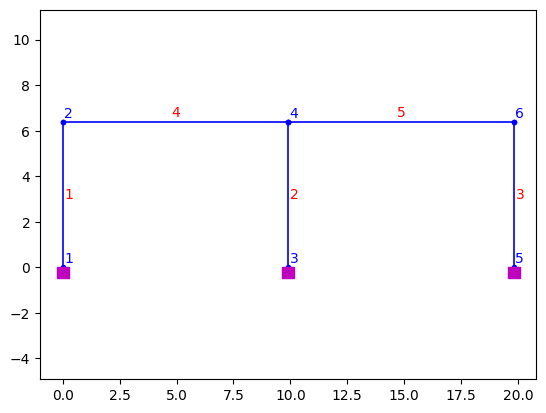

In [36]:
fig = plt.figure(figsize=(20, 6))
fig.subplots_adjust(left=.08, bottom=.08, right=.94, top=.94)
# ax1 = plt.subplot(111)

opsv.plot_model()

## Επεξεργασία αποτελεσμάτων

### Ανάγνωση εντατικών μεγεθών από το OpenSees

#### Σύμφωνα με τους τοπικούς άξονες του OpenSees

In [37]:
results_df = pd.DataFrame(data=results_ele,
                          columns =['load_case', 'elem_id', 'elem_type', 'Fxi_', 'Fyi_', 'Mi_', 'Fxj_', 'Fyj_', 'Mj_'])
# results_df.round(2)
results_df[results_df['load_case']=='G-1'].round(2)

,load_case,elem_id,elem_type,Fxi_,Fyi_,Mi_,Fxj_,Fyj_,Mj_
5,G-1,1,col,38.08,234.62,-67.71,-38.08,-234.62,-176.00
6,G-1,2,col,-39.77,289.01,91.31,39.77,-289.01,163.22
7,G-1,3,col,1.69,-20.16,6.62,-1.69,20.16,-17.44
8,G-1,4,beam,0.00,234.62,176.00,0.00,268.85,-345.40
9,G-1,5,beam,0.00,20.16,182.18,0.00,-20.16,17.44


#### Μετατροπή των τοπικών αξόνων σε M-V-N (σύμφωνα με τα αποτελέσματα του SAP)

In [38]:
def ops_to_mvn(row):
    if row['elem_type'] == 'col':
        Ni = - row['Fyi_']
        Nj = + row['Fyj_']
        Vi = - row['Fxi_']
        Vj = + row['Fxj_']
        Mi = + row['Mi_']
        Mj = - row['Mj_']
    else:
        Ni = - row['Fxi_']
        Nj = row['Fxj_']
        Vi = - row['Fyi_']
        Vj = + row['Fyj_']  
        Mi = - row['Mi_']
        Mj = + row['Mj_']
    return Ni, Nj, Vi, Vj, Mi, Mj


results_df['Ni'], results_df['Nj'], results_df['Vi'], results_df['Vj'], \
    results_df['Mi'], results_df['Mj'] = zip(*results_df.apply(ops_to_mvn, axis=1))

results_df.round(2)

,load_case,elem_id,elem_type,Fxi_,Fyi_,Mi_,Fxj_,Fyj_,Mj_,Ni,Nj,Vi,Vj,Mi,Mj
0,Ex,1,col,-42.15,-20.13,150.94,42.15,20.13,118.82,20.13,20.13,42.15,42.15,150.94,-118.82
1,Ex,2,col,-51.81,-0.00,170.67,51.81,0.00,160.90,0.00,0.00,51.81,51.81,170.67,-160.90
2,Ex,3,col,-42.15,20.13,150.94,42.15,-20.13,118.82,-20.13,-20.13,42.15,42.15,150.94,-118.82
3,Ex,4,beam,0.00,-20.13,-118.82,0.00,20.13,-80.45,-0.00,0.00,20.13,20.13,118.82,-80.45
4,Ex,5,beam,0.00,-20.13,-80.45,0.00,20.13,-118.82,-0.00,0.00,20.13,20.13,80.45,-118.82
5,G-1,1,col,38.08,234.62,-67.71,-38.08,-234.62,-176.00,-234.62,-234.62,-38.08,-38.08,-67.71,176.00
6,G-1,2,col,-39.77,289.01,91.31,39.77,-289.01,163.22,-289.01,-289.01,39.77,39.77,91.31,-163.22
7,G-1,3,col,1.69,-20.16,6.62,-1.69,20.16,-17.44,20.16,20.16,-1.69,-1.69,6.62,17.44
8,G-1,4,beam,0.00,234.62,176.00,0.00,268.85,-345.40,-0.00,0.00,-234.62,268.85,-176.00,-345.40
9,G-1,5,beam,0.00,20.16,182.18,0.00,-20.16,17.44,-0.00,0.00,-20.16,-20.16,-182.18,17.44


### Εντατικά μεγέθη για τα στοιχεία 1, 2, 4

In [39]:
# Στήλες: load_case, elem_id, location, N, M, V
# Γραμμές: Στοιχεία 1, 2, 4

load_cases = list(results_df['load_case'].unique())
elements = [1, 2, 4]
locations = ['i', 'j']

# Collect all rows in a list
rows = []

for lc in load_cases:
    for element in elements:
        for loc in locations:
            _N = float(results_df.loc[(results_df['load_case']==lc) & (results_df['elem_id']==element)]['N'+loc].iloc[0])
            _V = float(results_df.loc[(results_df['load_case']==lc) & (results_df['elem_id']==element)]['V'+loc].iloc[0])
            _M = float(results_df.loc[(results_df['load_case']==lc) & (results_df['elem_id']==element)]['M'+loc].iloc[0])
            
            # Add row as dictionary to the list
            rows.append({
                'load_case': lc,
                'elem_id': element,
                'location': loc,
                'N': _N,
                'V': _V,
                'M': _M
            })

# Create DataFrame from all rows at once - more efficient and avoids warning
df_selected = pd.DataFrame(rows)

df_selected.round(2)



,load_case,elem_id,location,N,V,M
0,Ex,1,i,20.13,42.15,150.94
1,Ex,1,j,20.13,42.15,-118.82
2,Ex,2,i,0.00,51.81,170.67
3,Ex,2,j,0.00,51.81,-160.90
4,Ex,4,i,-0.00,20.13,118.82
5,Ex,4,j,0.00,20.13,-80.45
6,G-1,1,i,-234.62,-38.08,-67.71
7,G-1,1,j,-234.62,-38.08,176.00
8,G-1,2,i,-289.01,39.77,91.31
9,G-1,2,j,-289.01,39.77,-163.22


## Συνδυασμοί δράσεων - Εναλλακτές φορτίσεις

In [40]:
# D-D, D-E, E-D
# G+0.3Q+Ex, G+0.3Q-Ex

combos = ['D-D', 'D-E', 'E-D', 'G+0.3Q+Ex', 'G+0.3Q-Ex']

dict_selected = {}
for lc in load_cases:
    dict_selected[lc] = df_selected[df_selected['load_case']==lc]

    
load_cases = list(results_df['load_case'].unique())
elements = [1, 2, 4]
locations = ['i', 'j']


combo_records = []


for element in elements:
    for loc in locations:
        dict_mvn = {}
        for lc in load_cases:
            dict_mvn[lc] = tuple(df_selected.loc[(df_selected['load_case']==lc) &
                                (df_selected['elem_id']==element) &
                                (df_selected['location']==loc)][['N', 'V', 'M']].values[0])
            
        combo_records.append({
            'combo': 'D-D',
            'elem_id': element,
            'location': loc,
            'N': 1.35 * (dict_mvn['G-1'][0] + dict_mvn['G-2'][0]) + 1.5 * (dict_mvn['Q-1'][0] + dict_mvn['Q-2'][0]),
            'V': 1.35 * (dict_mvn['G-1'][1] + dict_mvn['G-2'][1]) + 1.5 * (dict_mvn['Q-1'][1] + dict_mvn['Q-2'][1]),
            'M': 1.35 * (dict_mvn['G-1'][2] + dict_mvn['G-2'][2]) + 1.5 * (dict_mvn['Q-1'][2] + dict_mvn['Q-2'][2])
        })
 
        combo_records.append({
            'combo': 'D-E',
            'elem_id': element,
            'location': loc,
            'N': 1.35 * dict_mvn['G-1'][0] + dict_mvn['G-2'][0] + 1.5 * dict_mvn['Q-1'][0],
            'V': 1.35 * dict_mvn['G-1'][1] + dict_mvn['G-2'][1] + 1.5 * dict_mvn['Q-1'][1],
            'M': 1.35 * dict_mvn['G-1'][2] + dict_mvn['G-2'][2] + 1.5 * dict_mvn['Q-1'][2]
        })

        combo_records.append({
            'combo': 'E-D',
            'elem_id': element,
            'location': loc,
            'N': 1.35 * dict_mvn['G-2'][0] + dict_mvn['G-1'][0] + 1.5 * dict_mvn['Q-2'][0],
            'V': 1.35 * dict_mvn['G-2'][1] + dict_mvn['G-1'][1] + 1.5 * dict_mvn['Q-2'][1],
            'M': 1.35 * dict_mvn['G-2'][2] + dict_mvn['G-1'][2] + 1.5 * dict_mvn['Q-2'][2]
        })
        
        combo_records.append({
            'combo': 'G+0.3Q+Ex',
            'elem_id': element,
            'location': loc,
            'N': dict_mvn['G-1'][0] + dict_mvn['G-2'][0] + 0.3 * (dict_mvn['Q-1'][0] + dict_mvn['Q-2'][0]) + dict_mvn['Ex'][0],
            'V': dict_mvn['G-1'][1] + dict_mvn['G-2'][1] + 0.3 * (dict_mvn['Q-1'][1] + dict_mvn['Q-2'][1]) + dict_mvn['Ex'][1],
            'M': dict_mvn['G-1'][2] + dict_mvn['G-2'][2] + 0.3 * (dict_mvn['Q-1'][2] + dict_mvn['Q-2'][2]) + dict_mvn['Ex'][2]
        })

        combo_records.append({
            'combo': 'G+0.3Q-Ex',
            'elem_id': element,
            'location': loc,
            'N': dict_mvn['G-1'][0] + dict_mvn['G-2'][0] + 0.3 * (dict_mvn['Q-1'][0] + dict_mvn['Q-2'][0]) - dict_mvn['Ex'][0],
            'V': dict_mvn['G-1'][1] + dict_mvn['G-2'][1] + 0.3 * (dict_mvn['Q-1'][1] + dict_mvn['Q-2'][1]) - dict_mvn['Ex'][1],
            'M': dict_mvn['G-1'][2] + dict_mvn['G-2'][2] + 0.3 * (dict_mvn['Q-1'][2] + dict_mvn['Q-2'][2]) - dict_mvn['Ex'][2]
        })

df_combos = pd.DataFrame.from_records(combo_records)

df_combos.round(2)

,combo,elem_id,location,N,V,M
0,D-D,1,i,-446.08,-75.69,-154.60
1,D-E,1,i,-467.86,-77.52,-147.45
2,E-D,1,i,-192.68,-34.56,-81.48
3,G+0.3Q+Ex,1,i,-225.64,0.45,65.76
4,G+0.3Q-Ex,1,i,-265.90,-83.85,-236.12
5,D-D,1,j,-446.08,-75.69,329.81
6,D-E,1,j,-467.86,-77.52,348.64
7,E-D,1,j,-192.68,-34.56,139.73
8,G+0.3Q+Ex,1,j,-225.64,0.45,62.89
9,G+0.3Q-Ex,1,j,-265.90,-83.85,300.53


### Διάκριση σε σεισμικούς συνδυασμούς και μη

In [41]:
df_combos_grav = df_combos.where(df_combos['combo'].str.find('Ex')==-1).dropna()
df_combos_seismic = df_combos.where(df_combos['combo'].str.find('Ex')!=-1).dropna()

display(df_combos_grav)
display(df_combos_seismic)

,combo,elem_id,location,N,V,M
0,D-D,1.0,i,-446.080124,-7.568940e+01,-1.546019e+02
1,D-E,1.0,i,-467.856553,-7.751516e+01,-1.474528e+02
2,E-D,1.0,i,-192.684185,-3.456321e+01,-8.147656e+01
5,D-D,1.0,j,-446.080124,-7.568940e+01,3.298102e+02
6,D-E,1.0,j,-467.856553,-7.751516e+01,3.486442e+02
7,E-D,1.0,j,-192.684185,-3.456321e+01,1.397280e+02
10,D-D,2.0,i,-1202.282268,1.257661e-13,3.666401e-13
11,D-E,2.0,i,-890.149969,4.295195e+01,9.861127e+01
12,E-D,2.0,i,-890.149969,-4.295195e+01,-9.861127e+01
15,D-D,2.0,j,-1202.282268,1.257661e-13,-4.476419e-13


,combo,elem_id,location,N,V,M
3,G+0.3Q+Ex,1.0,i,-225.644379,0.448396,65.763979
4,G+0.3Q-Ex,1.0,i,-265.900167,-83.852045,-236.122881
8,G+0.3Q+Ex,1.0,j,-225.644379,0.448396,62.894244
9,G+0.3Q-Ex,1.0,j,-265.900167,-83.852045,300.530205
13,G+0.3Q+Ex,2.0,i,-662.409353,51.806942,170.668089
14,G+0.3Q-Ex,2.0,i,-662.409353,-51.806942,-170.668089
18,G+0.3Q+Ex,2.0,j,-662.409353,51.806942,-160.896342
19,G+0.3Q-Ex,2.0,j,-662.409353,-51.806942,160.896342
23,G+0.3Q+Ex,4.0,i,-0.000000,-225.644379,-62.894244
24,G+0.3Q-Ex,4.0,i,0.000000,-265.900167,-300.530205


## Περιβάλλουσες

### Περιβάλλουσα για συνδυασμούς χωρίς σεισμό

In [42]:
# Create envelope for gravity load combinations
env_grav_records = []

for element in elements:
    for loc in locations:
        df_temp = df_combos_grav.loc[(df_combos_grav['elem_id']==element) & (df_combos_grav['location']==loc)]

        minM = df_temp['M'].min()
        minV = df_temp['V'].min()
        N_for_minM = float(df_temp.loc[df_temp['M']==minM]['N'].iloc[0])
        maxM = df_temp['M'].max()
        maxV = df_temp['V'].max()
        N_for_maxM = float(df_temp.loc[df_temp['M']==maxM]['N'].iloc[0])

        env_grav_records.append({
            'elem_id': element,
            'location': loc,
            'min-max': 'min',                            
            'N(exM)': N_for_minM,
            'exM': minM,
            'exV': minV
        })

        env_grav_records.append({
            'elem_id': element,
            'location': loc,
            'min-max': 'max',                            
            'N(exM)': N_for_maxM,
            'exM': maxM,
            'exV': maxV
        })

# Create DataFrame from the records
df_env_grav = pd.DataFrame.from_records(env_grav_records)
df_env_grav.set_index(['elem_id', 'location', 'min-max'], inplace=True)
df_env_grav.round(2)

N(exM)      exM     exV
elem_id location min-max                         
1       i        min     -446.08  -154.60  -77.52
                 max     -192.68   -81.48  -34.56
        j        min     -192.68   139.73  -77.52
                 max     -467.86   348.64  -34.56
2       i        min     -890.15   -98.61  -42.95
                 max     -890.15    98.61   42.95
        j        min     -890.15  -176.28  -42.95
                 max     -890.15   176.28   42.95
4       i        min       -0.00  -348.64 -467.86
                 max       -0.00  -139.73 -192.68
        j        min        0.00 -1097.36  310.79
                 max        0.00  -724.33  601.14

### Περιβάλλουσα για σεισμικούς συνδυασμούς

In [43]:
# Create envelope for seismic combinations
env_seismic_records = []

for element in elements:
    for loc in locations:
        df_temp = df_combos_seismic.loc[(df_combos_seismic['elem_id']==element) & (df_combos_seismic['location']==loc)]

        minM = df_temp['M'].min()
        minV = df_temp['V'].min()
        N_for_minM = float(df_temp.loc[df_temp['M']==minM]['N'].iloc[0])
        maxM = df_temp['M'].max()
        maxV = df_temp['V'].max()
        N_for_maxM = float(df_temp.loc[df_temp['M']==maxM]['N'].iloc[0])

        env_seismic_records.append({
            'elem_id': element,
            'location': loc,
            'min-max': 'min',                            
            'N(exM)': N_for_minM,
            'exM': minM,
            'exV': minV
        })

        env_seismic_records.append({
            'elem_id': element,
            'location': loc,
            'min-max': 'max',                            
            'N(exM)': N_for_maxM,
            'exM': maxM,
            'exV': maxV
        })

# Create DataFrame from the records
df_env_seismic = pd.DataFrame.from_records(env_seismic_records)
df_env_seismic.set_index(['elem_id', 'location', 'min-max'], inplace=True)
df_env_seismic.round(2)

N(exM)     exM     exV
elem_id location min-max                        
1       i        min     -265.90 -236.12  -83.85
                 max     -225.64   65.76    0.45
        j        min     -225.64   62.89  -83.85
                 max     -265.90  300.53    0.45
2       i        min     -662.41 -170.67  -51.81
                 max     -662.41  170.67   51.81
        j        min     -662.41 -160.90  -51.81
                 max     -662.41  160.90   51.81
4       i        min        0.00 -300.53 -265.90
                 max       -0.00  -62.89 -225.64
        j        min        0.00 -685.05  311.08
                 max        0.00 -524.15  351.33